In [1]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import FRUnet
from ImageLoader import ImageLoader2D

In [2]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

current_datetime = datetime.datetime.now()
ct = "_".join([str(current_datetime.year), str(current_datetime.month), str(current_datetime.day), str(current_datetime.hour), str(current_datetime.minute), str(current_datetime.second)])

model_type = "FRUnet"

progress_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 600
min_loss_for_saving = 0.9

In [4]:
# Loading the data

X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 40


40it [00:05,  7.14it/s]


In [5]:
# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

In [6]:
# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [7]:
# Creating the model

model = FRUnet.create_model(img_height=img_size, img_width=img_size, input_channels=3, out_classes=1, starting_filters=filters)

In [8]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [9]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
8/8 [==============================] - 19s 198ms/step - loss: 0.7134 - val_loss: 0.8074
Loss Validation: 0.8073846
Loss Test: 0.7796292
Saved model with val_loss:  0.8073846


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 1
Learning Rate: 0.0001
8/8 [==============================] - 1s 106ms/step - loss: 0.6511 - val_loss: 0.8098
Loss Validation: 0.8097634
Loss Test: 0.78470206
Training, epoch 2
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.6359 - val_loss: 0.8144
Loss Validation: 0.8144366
Loss Test: 0.7897587
Training, epoch 3
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.6146 - val_loss: 0.8305
Loss Validation: 0.8305498
Loss Test: 0.8110211
Training, epoch 4
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.6194 - val_loss: 0.8348
Loss Validation: 0.83476603
Loss Test: 0.81721175
Training, epoch 5
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.5716 - val_loss: 0.8251
Loss Validation: 0.8251325
Loss Test: 0.7966235
Training, epoch 6
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.5738 - val_loss: 0.

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 20
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.4780 - val_loss: 0.7569
Loss Validation: 0.75692683
Loss Test: 0.68176615
Saved model with val_loss:  0.75692683


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 21
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.4935 - val_loss: 0.9757
Loss Validation: 0.9756719
Loss Test: 0.978885
Training, epoch 22
Learning Rate: 0.0001
8/8 [==============================] - 1s 100ms/step - loss: 0.5237 - val_loss: 0.8967
Loss Validation: 0.8966915
Loss Test: 0.8871784
Training, epoch 23
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.4616 - val_loss: 0.8654
Loss Validation: 0.8654294
Loss Test: 0.9335563
Training, epoch 24
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.4887 - val_loss: 0.7629
Loss Validation: 0.762884
Loss Test: 0.8207065
Training, epoch 25
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.5026 - val_loss: 0.7387
Loss Validation: 0.7386539
Loss Test: 0.66864026
Saved model with val_loss:  0.7386539


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 26
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.4449 - val_loss: 0.7622
Loss Validation: 0.7622059
Loss Test: 0.70084
Training, epoch 27
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.4619 - val_loss: 0.7635
Loss Validation: 0.76353186
Loss Test: 0.69939566
Training, epoch 28
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.4262 - val_loss: 0.7499
Loss Validation: 0.7498802
Loss Test: 0.6673648
Training, epoch 29
Learning Rate: 0.0001
8/8 [==============================] - 1s 99ms/step - loss: 0.4387 - val_loss: 0.8890
Loss Validation: 0.8889948
Loss Test: 0.85421544
Training, epoch 30
Learning Rate: 0.0001
8/8 [==============================] - 1s 100ms/step - loss: 0.4389 - val_loss: 0.8552
Loss Validation: 0.8552277
Loss Test: 0.8113797
Training, epoch 31
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.4658 - val_loss:

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 34
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.4076 - val_loss: 0.7799
Loss Validation: 0.7798673
Loss Test: 0.6452149
Training, epoch 35
Learning Rate: 0.0001
8/8 [==============================] - 1s 100ms/step - loss: 0.3707 - val_loss: 0.8314
Loss Validation: 0.83139205
Loss Test: 0.7764278
Training, epoch 36
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.4635 - val_loss: 0.7676
Loss Validation: 0.767632
Loss Test: 0.63482773
Training, epoch 37
Learning Rate: 0.0001
8/8 [==============================] - 1s 100ms/step - loss: 0.4264 - val_loss: 0.7648
Loss Validation: 0.7647914
Loss Test: 0.66418165
Training, epoch 38
Learning Rate: 0.0001
8/8 [==============================] - 1s 100ms/step - loss: 0.4214 - val_loss: 0.7900
Loss Validation: 0.7899835
Loss Test: 0.6621977
Training, epoch 39
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.4413 - val_los

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 56
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.4171 - val_loss: 0.7072
Loss Validation: 0.7072009
Loss Test: 0.61337924
Training, epoch 57
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.3802 - val_loss: 0.6989
Loss Validation: 0.69893324
Loss Test: 0.59588814
Training, epoch 58
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.4293 - val_loss: 0.6664
Loss Validation: 0.6663561
Loss Test: 0.5618215
Saved model with val_loss:  0.6663561


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 59
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3710 - val_loss: 0.7022
Loss Validation: 0.70224464
Loss Test: 0.6280654
Training, epoch 60
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3994 - val_loss: 0.7086
Loss Validation: 0.7086132
Loss Test: 0.60808325
Training, epoch 61
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3771 - val_loss: 0.7104
Loss Validation: 0.71038544
Loss Test: 0.58595586
Training, epoch 62
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3965 - val_loss: 0.7099
Loss Validation: 0.70990264
Loss Test: 0.57254153
Training, epoch 63
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3891 - val_loss: 0.7514
Loss Validation: 0.751444
Loss Test: 0.6054826
Training, epoch 64
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3866 - val_

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 71
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.4174 - val_loss: 0.5659
Loss Validation: 0.5658927
Loss Test: 0.4815331
Saved model with val_loss:  0.5658927


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 72
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3946 - val_loss: 0.5030
Loss Validation: 0.5030485
Loss Test: 0.40600145
Saved model with val_loss:  0.5030485


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 73
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.3738 - val_loss: 0.7201
Loss Validation: 0.72012496
Loss Test: 0.57576656
Training, epoch 74
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.3659 - val_loss: 0.4836
Loss Validation: 0.48362815
Loss Test: 0.37127388
Saved model with val_loss:  0.48362815


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 75
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3905 - val_loss: 0.5035
Loss Validation: 0.50350547
Loss Test: 0.35021424
Training, epoch 76
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3506 - val_loss: 0.5586
Loss Validation: 0.5585934
Loss Test: 0.35222918
Training, epoch 77
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.3323 - val_loss: 0.5981
Loss Validation: 0.59809554
Loss Test: 0.43229228
Training, epoch 78
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3856 - val_loss: 0.6017
Loss Validation: 0.60167366
Loss Test: 0.39144623
Training, epoch 79
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.3637 - val_loss: 0.4440
Loss Validation: 0.44400948
Loss Test: 0.2747252
Saved model with val_loss:  0.44400948


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 80
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.4077 - val_loss: 0.4854
Loss Validation: 0.48542225
Loss Test: 0.27071398
Training, epoch 81
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3553 - val_loss: 0.5432
Loss Validation: 0.54320586
Loss Test: 0.25591356
Training, epoch 82
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3586 - val_loss: 0.5012
Loss Validation: 0.5011522
Loss Test: 0.27123505
Training, epoch 83
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3525 - val_loss: 0.4479
Loss Validation: 0.4479375
Loss Test: 0.2953511
Training, epoch 84
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.4212 - val_loss: 0.4294
Loss Validation: 0.4293903
Loss Test: 0.23514444
Saved model with val_loss:  0.4293903


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 85
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3435 - val_loss: 0.4450
Loss Validation: 0.44503438
Loss Test: 0.21413946
Training, epoch 86
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.4064 - val_loss: 0.4927
Loss Validation: 0.49266702
Loss Test: 0.24383235
Training, epoch 87
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3626 - val_loss: 0.5109
Loss Validation: 0.51088846
Loss Test: 0.23922133
Training, epoch 88
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3644 - val_loss: 0.4962
Loss Validation: 0.49621367
Loss Test: 0.2326411
Training, epoch 89
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3276 - val_loss: 0.3965
Loss Validation: 0.39651692
Loss Test: 0.19426477
Saved model with val_loss:  0.39651692


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 90
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3674 - val_loss: 0.4524
Loss Validation: 0.45239252
Loss Test: 0.21983308
Training, epoch 91
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3922 - val_loss: 0.5392
Loss Validation: 0.5391778
Loss Test: 0.23516405
Training, epoch 92
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3457 - val_loss: 0.5113
Loss Validation: 0.51128054
Loss Test: 0.26791006
Training, epoch 93
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.3739 - val_loss: 0.4730
Loss Validation: 0.47298604
Loss Test: 0.24726403
Training, epoch 94
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3431 - val_loss: 0.5615
Loss Validation: 0.5615355
Loss Test: 0.24658442
Training, epoch 95
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3690 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 111
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.3672 - val_loss: 0.4853
Loss Validation: 0.4852935
Loss Test: 0.24474818
Training, epoch 112
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3597 - val_loss: 0.5013
Loss Validation: 0.50126016
Loss Test: 0.31051797
Training, epoch 113
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3618 - val_loss: 0.6222
Loss Validation: 0.62219036
Loss Test: 0.3094316
Training, epoch 114
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3193 - val_loss: 0.5181
Loss Validation: 0.518113
Loss Test: 0.25072825
Training, epoch 115
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.3453 - val_loss: 0.4640
Loss Validation: 0.46398664
Loss Test: 0.23401147
Training, epoch 116
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.3290

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 136
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.3767 - val_loss: 0.4391
Loss Validation: 0.4391253
Loss Test: 0.2456789
Training, epoch 137
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.3514 - val_loss: 0.4107
Loss Validation: 0.41072947
Loss Test: 0.2162081
Training, epoch 138
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3137 - val_loss: 0.4180
Loss Validation: 0.4180103
Loss Test: 0.23637795
Training, epoch 139
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3486 - val_loss: 0.3803
Loss Validation: 0.38030452
Loss Test: 0.24211931
Saved model with val_loss:  0.38030452


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 140
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.3492 - val_loss: 0.3970
Loss Validation: 0.39702797
Loss Test: 0.21204966
Training, epoch 141
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3310 - val_loss: 0.3682
Loss Validation: 0.36815804
Loss Test: 0.22999918
Saved model with val_loss:  0.36815804


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 142
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2759 - val_loss: 0.4480
Loss Validation: 0.44801545
Loss Test: 0.28115392
Training, epoch 143
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2799 - val_loss: 0.3895
Loss Validation: 0.3895173
Loss Test: 0.19315076
Training, epoch 144
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3195 - val_loss: 0.5259
Loss Validation: 0.5259293
Loss Test: 0.25187212
Training, epoch 145
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.3380 - val_loss: 0.4251
Loss Validation: 0.42510098
Loss Test: 0.2656368
Training, epoch 146
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3107 - val_loss: 0.4121
Loss Validation: 0.41211247
Loss Test: 0.2490027
Training, epoch 147
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3487

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 192
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.2909 - val_loss: 0.3712
Loss Validation: 0.37123019
Loss Test: 0.19589823
Training, epoch 193
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2828 - val_loss: 0.3601
Loss Validation: 0.3600576
Loss Test: 0.15934289
Saved model with val_loss:  0.3600576


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 194
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.2783 - val_loss: 0.4734
Loss Validation: 0.4734115
Loss Test: 0.23469108
Training, epoch 195
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3451 - val_loss: 0.4993
Loss Validation: 0.4992547
Loss Test: 0.21737093
Training, epoch 196
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3577 - val_loss: 0.5139
Loss Validation: 0.51389533
Loss Test: 0.20559293
Training, epoch 197
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2896 - val_loss: 0.4017
Loss Validation: 0.4017123
Loss Test: 0.19701326
Training, epoch 198
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3136 - val_loss: 0.4619
Loss Validation: 0.4618622
Loss Test: 0.22265774
Training, epoch 199
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2888

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 211
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.3319 - val_loss: 0.4005
Loss Validation: 0.40047985
Loss Test: 0.16303551
Training, epoch 212
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.2977 - val_loss: 0.4045
Loss Validation: 0.40447515
Loss Test: 0.18315089
Training, epoch 213
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3029 - val_loss: 0.4068
Loss Validation: 0.4067943
Loss Test: 0.18139493
Training, epoch 214
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2732 - val_loss: 0.3823
Loss Validation: 0.38230342
Loss Test: 0.18552983
Training, epoch 215
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2763 - val_loss: 0.4142
Loss Validation: 0.41418862
Loss Test: 0.1823076
Training, epoch 216
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.29

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 224
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2875 - val_loss: 0.3689
Loss Validation: 0.36891264
Loss Test: 0.18225116
Training, epoch 225
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2998 - val_loss: 0.3409
Loss Validation: 0.3408723
Loss Test: 0.17127872
Training, epoch 226
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.3162 - val_loss: 0.3705
Loss Validation: 0.37045592
Loss Test: 0.21418351
Training, epoch 227
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2730 - val_loss: 0.3447
Loss Validation: 0.34473222
Loss Test: 0.16874284
Training, epoch 228
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2986 - val_loss: 0.4039
Loss Validation: 0.4038636
Loss Test: 0.19893974
Training, epoch 229
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.25

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 324
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2708 - val_loss: 0.3257
Loss Validation: 0.3257457
Loss Test: 0.15673065
Training, epoch 325
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2965 - val_loss: 0.3535
Loss Validation: 0.35348773
Loss Test: 0.16890496
Training, epoch 326
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2569 - val_loss: 0.3703
Loss Validation: 0.37028736
Loss Test: 0.17666423
Training, epoch 327
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2615 - val_loss: 0.3403
Loss Validation: 0.3403389
Loss Test: 0.1655482
Training, epoch 328
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2285 - val_loss: 0.3457
Loss Validation: 0.34571928
Loss Test: 0.17399609
Training, epoch 329
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.240

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 370
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2251 - val_loss: 0.3427
Loss Validation: 0.34271932
Loss Test: 0.18446904
Training, epoch 371
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2524 - val_loss: 0.3361
Loss Validation: 0.3360905
Loss Test: 0.17735195
Training, epoch 372
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2540 - val_loss: 0.3112
Loss Validation: 0.3112411
Loss Test: 0.17102343
Training, epoch 373
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2433 - val_loss: 0.3302
Loss Validation: 0.33024967
Loss Test: 0.18723738
Training, epoch 374
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2248 - val_loss: 0.3889
Loss Validation: 0.38894504
Loss Test: 0.2080372
Training, epoch 375
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.221

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 396
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2328 - val_loss: 0.3320
Loss Validation: 0.3320222
Loss Test: 0.19269419
Training, epoch 397
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2603 - val_loss: 0.3360
Loss Validation: 0.3359548
Loss Test: 0.18500721
Training, epoch 398
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2514 - val_loss: 0.3489
Loss Validation: 0.34885472
Loss Test: 0.19106334
Training, epoch 399
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2399 - val_loss: 0.3461
Loss Validation: 0.34608418
Loss Test: 0.21439004
Training, epoch 400
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2909 - val_loss: 0.2957
Loss Validation: 0.29566205
Loss Test: 0.15727091
Saved model with val_loss:  0.29566205


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 401
Learning Rate: 0.0001
8/8 [==============================] - 1s 106ms/step - loss: 0.2556 - val_loss: 0.2999
Loss Validation: 0.2999174
Loss Test: 0.17986721
Training, epoch 402
Learning Rate: 0.0001
8/8 [==============================] - 1s 101ms/step - loss: 0.2118 - val_loss: 0.3230
Loss Validation: 0.32300836
Loss Test: 0.17250514
Training, epoch 403
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2545 - val_loss: 0.3215
Loss Validation: 0.32149458
Loss Test: 0.14883453
Training, epoch 404
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2327 - val_loss: 0.3539
Loss Validation: 0.35387033
Loss Test: 0.18042225
Training, epoch 405
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2358 - val_loss: 0.4511
Loss Validation: 0.45107484
Loss Test: 0.27497226
Training, epoch 406
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 413
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.2440 - val_loss: 0.3287
Loss Validation: 0.32873946
Loss Test: 0.17282963
Training, epoch 414
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2217 - val_loss: 0.3126
Loss Validation: 0.31264937
Loss Test: 0.16792244
Training, epoch 415
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2194 - val_loss: 0.3149
Loss Validation: 0.3149073
Loss Test: 0.1472596
Training, epoch 416
Learning Rate: 0.0001
8/8 [==============================] - 1s 102ms/step - loss: 0.2425 - val_loss: 0.3481
Loss Validation: 0.34814256
Loss Test: 0.16781706
Training, epoch 417
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2290 - val_loss: 0.4433
Loss Validation: 0.4433326
Loss Test: 0.26003534
Training, epoch 418
Learning Rate: 0.0001
8/8 [==============================] - 1s 112ms/step - loss: 0.276

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 441
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2311 - val_loss: 0.3518
Loss Validation: 0.35175657
Loss Test: 0.14679086
Training, epoch 442
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2429 - val_loss: 0.3376
Loss Validation: 0.3376057
Loss Test: 0.15019095
Training, epoch 443
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2332 - val_loss: 0.2987
Loss Validation: 0.29866022
Loss Test: 0.1264872
Training, epoch 444
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2315 - val_loss: 0.2829
Loss Validation: 0.2829396
Loss Test: 0.12033111
Training, epoch 445
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.2430 - val_loss: 0.2974
Loss Validation: 0.29738903
Loss Test: 0.13716835
Training, epoch 446
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.245

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2023_9_19_18_14_38\assets


Training, epoch 510
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.2134 - val_loss: 0.3494
Loss Validation: 0.3493622
Loss Test: 0.19793892
Training, epoch 511
Learning Rate: 0.0001
8/8 [==============================] - 1s 105ms/step - loss: 0.2208 - val_loss: 0.3032
Loss Validation: 0.30319577
Loss Test: 0.16746485
Training, epoch 512
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.1904 - val_loss: 0.3174
Loss Validation: 0.31738436
Loss Test: 0.17355686
Training, epoch 513
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.2132 - val_loss: 0.2664
Loss Validation: 0.2664479
Loss Test: 0.13100064
Training, epoch 514
Learning Rate: 0.0001
8/8 [==============================] - 1s 103ms/step - loss: 0.1993 - val_loss: 0.3290
Loss Validation: 0.32901216
Loss Test: 0.16497028
Training, epoch 515
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.24

Loading the model
1/1 [==============================] - 0s 19ms/step


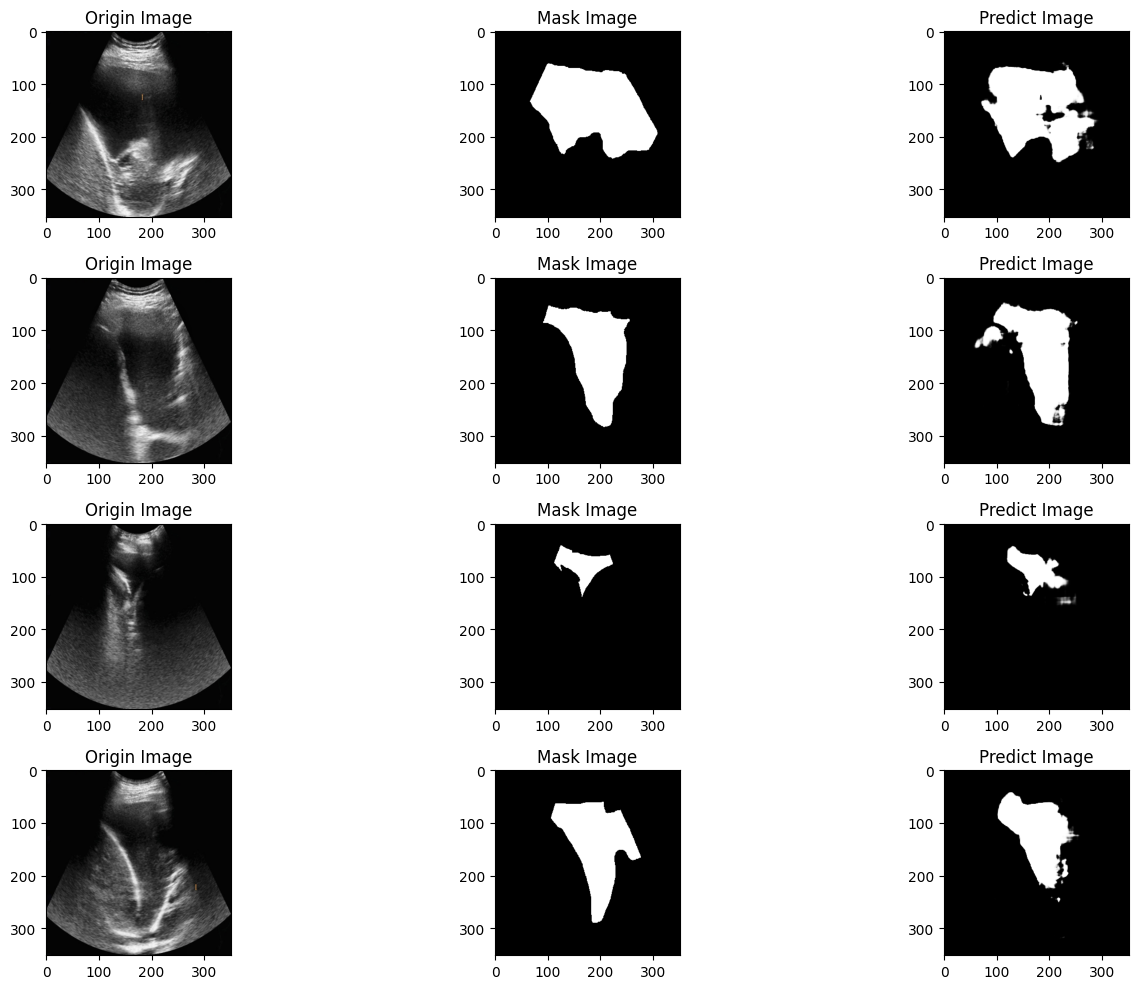

Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
results_FRUnet_17_kvasir.txt
File done


In [10]:
# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

fig, axs = plt.subplots(4, 3, figsize=(15, 10))

for i in range(len(prediction_test)):
    origin = x_test[i]
    origin = origin.squeeze()
    axs[i, 0].imshow(origin, cmap='gray') 
    axs[i, 0].set_title('Origin Image')

    mask = y_test[i]
    mask = mask.squeeze()
    axs[i, 1].imshow(mask, cmap='gray') 
    axs[i, 1].set_title('Mask Image')
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    axs[i, 2].imshow(pred, cmap='gray')
    axs[i, 2].set_title('Predict Image')

plt.tight_layout()
plt.show()

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')